# 匯入Tensorflow套件

In [1]:
import tensorflow
if tensorflow.__version__.startswith('1.'):
    import tensorflow as tf
    from tensorflow.python.platform import gfile
else:
    import tensorflow as v2
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
    import tensorflow.compat.v1.gfile as gfile
print("Tensorflow version:{}".format(tf.__version__))

Instructions for updating:
non-resource variables are not supported in the long term
Tensorflow version:2.5.0


# 匯入其他套件

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np

# 匯入資料集mnist

In [3]:
 (img_train, label_train), (img_test, label_test) = tf.keras.datasets.mnist.load_data()

# 查看資料集的type, shape, dtype訊息

In [4]:
print("img_train type:",type(img_train))
print("img_train shape:",img_train.shape)
print("img_train dtype:",img_train.dtype)
print("label_train type:",type(label_train))
print("label_train shape:",label_train.shape)
print("label_train dtype:",label_train.dtype)

img_train type: <class 'numpy.ndarray'>
img_train shape: (60000, 28, 28)
img_train dtype: uint8
label_train type: <class 'numpy.ndarray'>
label_train shape: (60000,)
label_train dtype: uint8


# 圖片顯示函數

In [5]:
def image_random_show(img_data,label_data,label2classname_dict,row=3,column=3):
    a = np.array([1])
    random_list = np.random.randint(0,img_data.shape[0], int(row * column))                           
    print("random_list:",random_list)
    
    #----設定圖片大小
    plt.figure(figsize=(7,7))
    #----display
    for i, rdm_number in enumerate(random_list):
        label = label_data[rdm_number]
        if type(label) == type(a):
            label = label[0]
        classname = label2classname_dict[label]

        plt.subplot(column,row,i+1)
        plt.axis('off')
        plt.title("{}".format(classname))
        
        if img_data.ndim == 3:
             plt.imshow(img_data[rdm_number],cmap='gray')
        else:
            plt.imshow(img_data[rdm_number])

    plt.show()

# 建立label轉換成類別名稱的字典集

In [5]:
label2classname_dict = {0:'zero',
                        1:"one",
                        2:"two",
                        3:"three",
                        4:"four",
                        5:"five",
                        6:"six",
                        7:"seven",
                        8:'eight',
                        9:"nine"}

random_list: [39997 33714  2907 57255 42151 43137  6548 39729 26854]


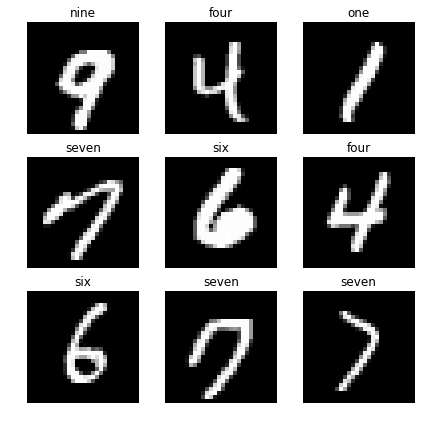

In [7]:
image_random_show(img_train,label_train,label2classname_dict=label2classname_dict,row=3,column=3)

random_list: [9420 8361 1745 7620 6288 9959 6004 2400 1469]


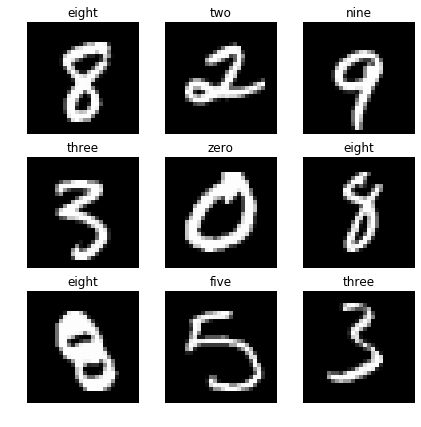

In [8]:
image_random_show(img_test,label_test,label2classname_dict=label2classname_dict,row=3,column=3)

# 建立計算圖

In [5]:
graph_1 = tf.Graph()
with graph_1.as_default():
    #----建立tf.placeholder()，接收非張量型態的資料
    tf_input = tf.placeholder(tf.float32,shape=[None,28,28],name='input')
    tf_label = tf.placeholder(tf.int32,shape=[None],name="label")
    
    #----建立類神經網路
    net = tf.layers.flatten(tf_input)
    print(net.shape)
    net = tf.layers.dense(inputs=net, units=100, activation=tf.nn.relu)
    print(net.shape)
    output = tf.layers.dense(inputs=net, units=10, activation=None)#輸出層就不需使用激勵函數
    print(output.shape)

    #----softmax函數輸出各類別的機率
    tf_prediction = tf.nn.softmax(output,name="prediction")

     #----設定損失函數
    tf_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_label,logits=output),
                      name="loss")

    #----設定最佳化函數
    learning_rate = 1e-4
    tf_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(tf_loss)

    #----GPU 資源設定
    config = tf.ConfigProto(log_device_placement=True,
                            allow_soft_placement=True)
    config.gpu_options.allow_growth = True

    sess = tf.Session(graph=graph_1,config=config)
    sess.run(tf.global_variables_initializer())

C:\Users\JohnnyKavnie\Anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
C:\Users\JohnnyKavnie\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\JohnnyKavnie\Anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '


(?, 784)
(?, 100)
(?, 10)
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



# 計算訓練的參數數量

In [8]:
def get_qty_var(tf_graph):
    qty = 0
    with tf_graph.as_default():
        for var in tf.global_variables():
            
            if var.trainable:
                shape = var.shape
                for i,num in enumerate(shape):
                    if i == 0:
                        product = num
                    else:
                        product *= num
                qty += product 

        print("參數數量 = ",qty)

In [111]:
get_qty_var(graph_1)

參數數量 =  79510


# 設定批次數量(batch size)

In [8]:
batch_size = 128

# 設定訓練週期(epoch)

In [9]:
epochs = 10

# 權重最佳化

In [12]:
#----計算迭代次數
iterations =math.ceil(img_train.shape[0] / batch_size)

for epoch in range(epochs):
    loss_train = 0
    for iteration in range(iterations):
        #----選取進行迭代的圖片
        num_start = batch_size * iteration
        num_end = num_start + batch_size
        if num_end > img_train.shape[0]:
            num_end = img_train.shape[0]

        ite_data = img_train[num_start:num_end]
        ite_label = label_train[num_start:num_end]
        
        #----權重最佳化
        sess.run(tf_optimizer,feed_dict={tf_input:ite_data,tf_label:ite_label})
        
        #----累加損失值
        loss_train += sess.run(tf_loss,feed_dict={tf_input:ite_data,tf_label:ite_label})

    #----計算平均損失值
    loss_train /= iterations
    print("loss_train = ",loss_train)

loss_train =  18.961702694008345
loss_train =  5.161735595035147
loss_train =  3.425633777878178
loss_train =  2.512377312903338
loss_train =  1.9379341648077406
loss_train =  1.538119407215797
loss_train =  1.2464155049236028
loss_train =  1.0247727491940533
loss_train =  0.8507054216143534
loss_train =  0.7089218667915178


In [13]:
#----計算迭代次數
iterations =math.ceil(img_train.shape[0] / batch_size)

for epoch in range(epochs):
    loss_train = 0
    for iteration in range(iterations):
        num_start = batch_size * iteration
        num_end = num_start + batch_size
        if num_end >= img_train.shape[0]:
            num_end = img_train.shape[0]

        ite_data = img_train[num_start:num_end]
        ite_label = label_train[num_start:num_end]

        sess.run(tf_optimizer,feed_dict={tf_input:ite_data,tf_label:ite_label})

        loss_train += sess.run(tf_loss,feed_dict={tf_input:ite_data,tf_label:ite_label})

    loss_train /= iterations
    print("loss_train = ",loss_train)

loss_train =  19.312923399624285
loss_train =  4.979539842493753
loss_train =  3.2775550967594707
loss_train =  2.4094338619124405
loss_train =  1.873642230712211
loss_train =  1.501644201889219
loss_train =  1.227631332165103
loss_train =  1.0150657033638888
loss_train =  0.845374993622005
loss_train =  0.7052292447097337


# 單張圖片的預測結果 

ite_data shape: (1, 28, 28)


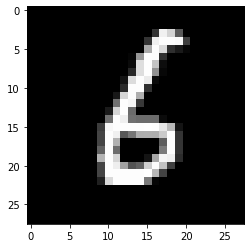

In [38]:
rdm_number = np.random.randint(0,len(img_train))

ite_data = img_train[rdm_number:rdm_number+1]
print("ite_data shape:",ite_data.shape)

plt.imshow(ite_data[0],cmap='gray')
plt.show()

In [39]:
prediction = sess.run(tf_prediction,feed_dict={tf_input:ite_data})
print("prediction shape:",prediction.shape)
print(prediction)

prediction shape: (1, 10)
[[3.6913826e-35 0.0000000e+00 4.9647961e-28 0.0000000e+00 0.0000000e+00
  1.4112593e-30 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


In [43]:
arg_prediction = np.argmax(prediction,axis=1)
print("預測類別:",arg_prediction)

ite_label = label_train[rdm_number:rdm_number+1]
print("正確答案:",ite_label)

預測類別: [6]
正確答案: [6]


# 將準確率的計算加入到訓練架構裡

In [12]:
#----計算迭代次數
iterations =math.ceil(img_train.shape[0] / batch_size)
for epoch in range(epochs):
    #----變數重置
    loss_train = 0
    correct_count = 0
    prediction_count = 0
    
    for iteration in range(iterations):
        num_start = batch_size * iteration
        num_end = num_start + batch_size
        if num_end >= img_train.shape[0]:
            num_end = img_train.shape[0]

        ite_data = img_train[num_start:num_end]
        ite_label = label_train[num_start:num_end]

        sess.run(tf_optimizer,feed_dict={tf_input:ite_data,tf_label:ite_label})

        loss_train += sess.run(tf_loss,feed_dict={tf_input:ite_data,tf_label:ite_label})
        prediction = sess.run(tf_prediction,feed_dict={tf_input:ite_data})
        arg_predictions = np.argmax(prediction,axis=1)
        for arg_prediction, label in zip(arg_predictions,ite_label):
            prediction_count += 1
            if arg_prediction == label:
                correct_count += 1

    loss_train /= iterations
    print("訓練集 損失值 = ",loss_train)
    print("訓練集 準確率 = ",correct_count/prediction_count)
    
    #----計算驗證集的損失值與準確率
    

訓練集 損失值 =  18.897037185712662
訓練集 準確率 =  0.6784166666666667
訓練集 損失值 =  4.979894632660249
訓練集 準確率 =  0.85445
訓練集 損失值 =  3.3227897911056528
訓練集 準確率 =  0.8868
訓練集 損失值 =  2.4769271111199216
訓練集 準確率 =  0.9052166666666667
訓練集 損失值 =  1.955485058092534
訓練集 準確率 =  0.9184333333333333
訓練集 損失值 =  1.5876341647218302
訓練集 準確率 =  0.9280166666666667
訓練集 損失值 =  1.308555233067518
訓練集 準確率 =  0.9361166666666667
訓練集 損失值 =  1.0898484974879703
訓練集 準確率 =  0.9431333333333334
訓練集 損失值 =  0.9105071438709956
訓練集 準確率 =  0.9493833333333334
訓練集 損失值 =  0.7634734666572767
訓練集 準確率 =  0.9549


# 加入圖形化所需的資料

In [13]:
#----計算迭代次數
iterations =math.ceil(img_train.shape[0] / batch_size)
iterations_test = math.ceil(img_test.shape[0] / batch_size )

#----宣告收集損失值與準確率的串列
loss_train_list = list()
acc_train_list = list()

In [21]:
for epoch in range(epochs):
    #----變數重置
    loss_train = 0
    correct_count = 0
    prediction_count = 0
    
    for iteration in range(iterations):
        num_start = batch_size * iteration
        num_end = num_start + batch_size
        if num_end > img_train.shape[0]:
            num_end = img_train.shape[0]

        ite_data = img_train[num_start:num_end]
        ite_label = label_train[num_start:num_end]

        sess.run(tf_optimizer,feed_dict={tf_input:ite_data,tf_label:ite_label})

        loss_train += sess.run(tf_loss,feed_dict={tf_input:ite_data,tf_label:ite_label})
        prediction = sess.run(tf_prediction,feed_dict={tf_input:ite_data})
        arg_predictions = np.argmax(prediction,axis=1)
        for arg_prediction, label in zip(arg_predictions,ite_label):
            prediction_count += 1
            if arg_prediction == label:
                correct_count += 1

    loss_train /= iterations
    acc_train = correct_count/prediction_count
    print("訓練集 損失值 = ",loss_train)
    print("訓練集 準確率 = ",acc_train)
    
    #----收集損失值與準確率數值至串列
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)

訓練集 損失值 =  0.12212283362033073
訓練集 準確率 =  0.9867
訓練集 損失值 =  0.1027311119575506
訓練集 準確率 =  0.9876666666666667
訓練集 損失值 =  0.08624743355769846
訓練集 準確率 =  0.9893666666666666
訓練集 損失值 =  0.07234774519312594
訓練集 準確率 =  0.9908666666666667
訓練集 損失值 =  0.059941720754325176
訓練集 準確率 =  0.9916833333333334
訓練集 損失值 =  0.049028948944653636
訓練集 準確率 =  0.9928333333333333
訓練集 損失值 =  0.041822613753812375
訓練集 準確率 =  0.9935333333333334
訓練集 損失值 =  0.03431806554692709
訓練集 準確率 =  0.9947166666666667
訓練集 損失值 =  0.030910632790629965
訓練集 準確率 =  0.9948833333333333
訓練集 損失值 =  0.02706017231847375
訓練集 準確率 =  0.9951833333333333


# 訓練集的圖形化

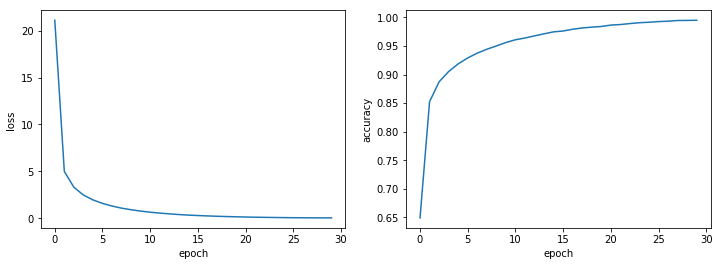

In [22]:
x_num = [i for i in range(0,len(loss_train_list))]

plt.figure(figsize=(12,4))#圖形的大小可以自行設定

plt.subplot(1,2,1)#設定第1張圖
plt.plot(x_num,loss_train_list)
plt.xlabel("epoch")
plt.ylabel("loss ")

plt.subplot(1,2,2)#設定第2張圖
plt.plot(x_num,acc_train_list)
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.show()#所有圖都設定完再執行show()

# 單獨計算驗證集的準確率

In [30]:
iterations_test = math.ceil(img_test.shape[0] / batch_size )
loss_test = 0
correct_count = 0
prediction_count = 0
for iteration in range(iterations_test):
    num_start = batch_size * iteration
    num_end = num_start + batch_size
    if num_end > img_test.shape[0]:
        num_end = img_test.shape[0]

    ite_data = img_test[num_start:num_end]
    ite_label = label_test[num_start:num_end]

    loss_test += sess.run(tf_loss,feed_dict={tf_input:ite_data,tf_label:ite_label})
    prediction = sess.run(tf_prediction,feed_dict={tf_input:ite_data})
    arg_predictions = np.argmax(prediction,axis=1)
    for arg_prediction, label in zip(arg_predictions,ite_label):
        prediction_count += 1
        if arg_prediction == label:
            correct_count += 1
loss_test /= iterations_test
print("驗證集 損失值 = ",loss_test)
print("驗證集 準確率 = ",correct_count/prediction_count)

驗證集 損失值 =  0.9968182463283632
驗證集 準確率 =  0.9501


# 加入驗證集的準確率計算

In [10]:
#----設定超參數
batch_size = 128
epochs = 10

#----計算迭代次數
iterations_train =math.ceil(img_train.shape[0] / batch_size)
iterations_test = math.ceil(img_test.shape[0] / batch_size )

#----宣告收集損失值與準確率的串列
loss_train_list = list()
acc_train_list = list()
loss_test_list = list()
acc_test_list = list()

In [15]:
for epoch in range(epochs):
    #----變數重置
    loss_train = 0
    correct_count = 0
    prediction_count = 0
    
    for iteration in range(iterations_train):
        num_start = batch_size * iteration
        num_end = num_start + batch_size
        if num_end > img_train.shape[0]:
            num_end = img_train.shape[0]

        ite_data = img_train[num_start:num_end]
        ite_label = label_train[num_start:num_end]

        sess.run(tf_optimizer,feed_dict={tf_input:ite_data,tf_label:ite_label})

        loss_train += sess.run(tf_loss,feed_dict={tf_input:ite_data,tf_label:ite_label})
        prediction = sess.run(tf_prediction,feed_dict={tf_input:ite_data})
        arg_predictions = np.argmax(prediction,axis=1)
        for arg_prediction, label in zip(arg_predictions,ite_label):
            prediction_count += 1
            if arg_prediction == label:
                correct_count += 1

    loss_train /= iterations_train
    acc_train = correct_count / prediction_count
    print("訓練集 損失值 = ",loss_train)
    print("訓練集 準確率 = ",acc_train)
    
    #----收集訓練集損失值與準確率數值至串列
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    
    #----計算驗證集的損失值與準確率
    loss_test = 0
    correct_count = 0
    prediction_count = 0
    for iteration in range(iterations_test):
        num_start = batch_size * iteration
        num_end = num_start + batch_size
        if num_end > img_test.shape[0]:
            num_end = img_test.shape[0]

        ite_data = img_test[num_start:num_end]
        ite_label = label_test[num_start:num_end]
        
        loss_test += sess.run(tf_loss,feed_dict={tf_input:ite_data,tf_label:ite_label})
        prediction = sess.run(tf_prediction,feed_dict={tf_input:ite_data})
        arg_predictions = np.argmax(prediction,axis=1)
        for arg_prediction, label in zip(arg_predictions,ite_label):
            prediction_count += 1
            if arg_prediction == label:
                correct_count += 1
    loss_test /= iterations_test
    acc_test = correct_count / prediction_count
    print("驗證集 損失值 = ",loss_test)
    print("驗證集 準確率 = ",acc_test)
    
    #----收集驗證集損失值與準確率數值至串列
    loss_test_list.append(loss_test)
    acc_test_list.append(acc_test)
    

訓練集 損失值 =  0.12921605089954327
訓練集 準確率 =  0.9873833333333333
驗證集 損失值 =  1.0461127871433569
驗證集 準確率 =  0.9449
訓練集 損失值 =  0.10954655096789649
訓練集 準確率 =  0.9881833333333333
驗證集 損失值 =  1.0722311334405743
驗證集 準確率 =  0.9463
訓練集 損失值 =  0.09685256922821588
訓練集 準確率 =  0.9894333333333334
驗證集 損失值 =  1.0648728159537164
驗證集 準確率 =  0.9459
訓練集 損失值 =  0.08361911938259119
訓練集 準確率 =  0.9904333333333334
驗證集 損失值 =  1.0281736885881765
驗證集 準確率 =  0.9476
訓練集 損失值 =  0.0710347178743547
訓練集 準確率 =  0.9913833333333333
驗證集 損失值 =  1.0094639000437176
驗證集 準確率 =  0.9483
訓練集 損失值 =  0.061411130883509135
訓練集 準確率 =  0.9922333333333333
驗證集 損失值 =  1.0012788895007183
驗證集 準確率 =  0.9465
訓練集 損失值 =  0.05074510490327767
訓練集 準確率 =  0.9933666666666666
驗證集 損失值 =  0.9704059523582841
驗證集 準確率 =  0.9509
訓練集 損失值 =  0.043932997669811076
訓練集 準確率 =  0.99395
驗證集 損失值 =  0.9889662997038152
驗證集 準確率 =  0.9504
訓練集 損失值 =  0.040852909375012285
訓練集 準確率 =  0.99365
驗證集 損失值 =  0.9832949856078087
驗證集 準確率 =  0.9532
訓練集 損失值 =  0.034814973604318504
訓練集 準確率

# 函數化

In [118]:
#----設定超參數
batch_size = 128
epochs = 5

#----計算迭代次數
iterations_train =math.ceil(img_train.shape[0] / batch_size)
iterations_test = math.ceil(img_test.shape[0] / batch_size )

#----宣告收集損失值與準確率的串列
loss_train_list = list()
acc_train_list = list()
loss_test_list = list()
acc_test_list = list()

In [4]:
def get_ite_data(img_data,label_data,ite_num,batch_size):
    num_start = batch_size * ite_num
    num_end = num_start + batch_size
    if num_end > img_data.shape[0]:
        num_end = img_data.shape[0]
    
    ite_data = img_data[num_start:num_end]
    ite_label = label_data[num_start:num_end]
    
    return ite_data,ite_label

In [5]:
def get_loss(img_data,label_data,batch_size,sess,use_dropout=False):
    iterations =math.ceil(img_data.shape[0] / batch_size)
    loss = 0
    
    for iteration in range(iterations):
        ite_data,ite_label = get_ite_data(img_data,label_data,iteration,batch_size)
        
        if use_dropout is False:
            loss += sess.run(tf_loss,feed_dict={tf_input:ite_data,tf_label:ite_label})
        else:
            loss += sess.run(tf_loss,feed_dict={tf_input:ite_data,
                                                tf_label:ite_label,
                                                tf_keep_prob:1})
    
    loss /= iterations
    
    return loss

In [6]:
def get_accuracy(img_data,label_data,batch_size,sess,use_dropout=False):
    iterations = math.ceil(img_data.shape[0] / batch_size)
    correct_count = 0
    prediction_count = 0
    
    for iteration in range(iterations):
        ite_data,ite_label = get_ite_data(img_data,label_data,iteration,batch_size)
        if use_dropout is False:
            predictions = sess.run(tf_prediction,feed_dict={tf_input:ite_data})
        else:
            predictions = sess.run(tf_prediction,feed_dict={tf_input:ite_data,
                                                tf_label:ite_label,
                                                tf_keep_prob:1})
        arg_predictions = np.argmax(predictions,axis=1)
        for arg_prediction, label in zip(arg_predictions,ite_label):
            prediction_count += 1
            if arg_prediction == label:
                correct_count += 1
    acc = correct_count / prediction_count
    
    return acc

In [9]:
acc_train = get_accuracy(img_train,label_train,batch_size,sess)
print("訓練集準確率:",acc_train)
acc_test = get_accuracy(img_test,label_test,batch_size,sess)
print("驗證集準確率:",acc_test)

訓練集準確率: 0.13143333333333335
驗證集準確率: 0.1298


In [119]:
for epoch in range(epochs):
    
    for iteration in range(iterations_train):
        
        ite_data,ite_label = get_ite_data(img_train,label_train,iteration,batch_size)
        
        sess.run(tf_optimizer,feed_dict={tf_input:ite_data,tf_label:ite_label})
        
    #----計算訓練集的損失值與準確率
    loss_train = get_loss(img_train,label_train,batch_size,sess)
    acc_train = get_accuracy(img_train,label_train,batch_size,sess)
    print("訓練集 損失值 = ",loss_train)
    print("訓練集 準確率 = ",acc_train)
    
    #----收集訓練集損失值與準確率數值至串列
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    
    #----計算驗證集的損失值與準確率
    loss_test = get_loss(img_test,label_test,batch_size,sess)
    acc_test = get_accuracy(img_test,label_test,batch_size,sess)
    print("驗證集 損失值 = ",loss_test)
    print("驗證集 準確率 = ",acc_test)
    
    #----收集驗證集損失值與準確率數值至串列
    loss_test_list.append(loss_test)
    acc_test_list.append(acc_test)
    

訓練集 損失值 =  0.03537827873740536
訓練集 準確率 =  0.9903333333333333
驗證集 損失值 =  0.5355155507896149
驗證集 準確率 =  0.9495
訓練集 損失值 =  0.02352442301464746
訓練集 準確率 =  0.9933333333333333
驗證集 損失值 =  0.5143530017340674
驗證集 準確率 =  0.9522
訓練集 損失值 =  0.021544857057954267
訓練集 準確率 =  0.9943333333333333
驗證集 損失值 =  0.498517595965052
驗證集 準確率 =  0.9545
訓練集 損失值 =  0.022604799328999177
訓練集 準確率 =  0.99315
驗證集 損失值 =  0.5096761622342548
驗證集 準確率 =  0.9538
訓練集 損失值 =  0.013240002874966104
訓練集 準確率 =  0.9957666666666667
驗證集 損失值 =  0.48545480366846266
驗證集 準確率 =  0.9562


# 訓練集與驗證集的圖形化

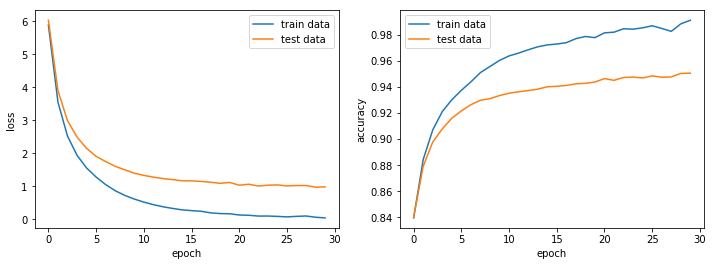

In [11]:
x_num = [i for i in range(0,len(loss_train_list))]

plt.figure(figsize=(12,4))#圖形的大小可以自行設定

plt.subplot(1,2,1)#設定第1張圖
plt.plot(x_num,loss_train_list,label='train data')
plt.plot(x_num,loss_test_list,label='test data')
plt.xlabel("epoch")
plt.ylabel("loss ")
plt.legend()

plt.subplot(1,2,2)#設定第2張圖
plt.plot(x_num,acc_train_list,label='train data')
plt.plot(x_num,acc_test_list,label='test data')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.show()#所有圖都設定完再執行show()

# 查看訓練集與驗證集最高的準確率

In [12]:
arg_train = np.argmax(acc_train_list)
best_acc_train = acc_train_list[arg_train]
print("訓練集最高的準確率為{}，出現在epoch {}".format(best_acc_train,arg_train))

arg_test = np.argmax(acc_test_list)
best_acc_test = acc_test_list[arg_test]
print("驗證集最高的準確率為{}，出現在epoch {}".format(best_acc_test,arg_test))

訓練集最高的準確率為0.99135，出現在epoch 29
驗證集最高的準確率為0.9507，出現在epoch 29


# 建立2層的神經元

In [19]:
graph_2 = tf.Graph()
with graph_2.as_default():
    
    #----建立tf.placeholder()，接收非張量型態的資料
    tf_input = tf.placeholder(tf.float32,shape=[None,28,28],name='input')
    tf_label = tf.placeholder(tf.int32,shape=[None],name="label")
    tf_keep_prob = tf.placeholder(tf.float32,name='keep_prob')
    
    #----建立類神經網路
    net = tf.layers.flatten(tf_input)
    print(net.shape)
    net = tf.layers.dense(inputs=net, units=100, activation=tf.nn.relu)
    print(net.shape)
    net = tf.layers.dense(inputs=net, units=200, activation=tf.nn.relu)
    print(net.shape)
    
    net = tf.nn.dropout(net, keep_prob=tf_keep_prob)#加入dropout
    
    output = tf.layers.dense(inputs=net, units=10, activation=None)#輸出層就不需使用激勵函數
    print(output.shape)

    #----softmax函數輸出各類別的機率
    tf_prediction = tf.nn.softmax(output,name="prediction")

     #----設定損失函數
    tf_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_label,logits=output),
                      name="loss")

    #----設定最佳化函數
    learning_rate = 1e-4
    tf_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(tf_loss)

    #----GPU 資源設定
    config = tf.ConfigProto(log_device_placement=True,
                            allow_soft_placement=True)
    config.gpu_options.allow_growth = True

    sess = tf.Session(graph=graph_2,config=config)
    sess.run(tf.global_variables_initializer())

(?, 784)
(?, 100)
(?, 200)
(?, 10)
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



In [9]:
get_qty_var(graph_1)

參數數量 =  79510


In [12]:
get_qty_var(graph_2)

參數數量 =  100710


# 訓練程式碼函數化

In [16]:
def run_training(*args,**kwargs):
    #----參數擷取
    img_train = args[0]
    label_train = args[1]
    img_test = args[2]
    label_test = args[3]
    sess = args[4]
    batch_size = kwargs['batch_size']
    epochs = kwargs['epochs']
    dropout_ratio = kwargs.get('dropout_ratio')
    
    #----計算迭代次數
    iterations_train =math.ceil(img_train.shape[0] / batch_size)
    iterations_test = math.ceil(img_test.shape[0] / batch_size )
    
    #----宣告收集損失值與準確率的串列
    loss_train_list = list()
    acc_train_list = list()
    loss_test_list = list()
    acc_test_list = list()
    
    for epoch in range(epochs):
        for iteration in range(iterations_train):
            ite_data,ite_label = get_ite_data(img_train,label_train,iteration,batch_size)
            if dropout_ratio is None:
                sess.run(tf_optimizer,feed_dict={tf_input:ite_data,tf_label:ite_label})
            else:
                sess.run(tf_optimizer,feed_dict={tf_input:ite_data,
                                                 tf_label:ite_label,
                                                 tf_keep_prob:1-dropout_ratio})
        
        #----計算訓練集的損失值與準確率
        if dropout_ratio is None:
            loss_train = get_loss(img_train,label_train,batch_size,sess)
            acc_train = get_accuracy(img_train,label_train,batch_size,sess)
        else:
            loss_train = get_loss(img_train,
                                  label_train,
                                  batch_size,sess,
                                  use_dropout=True)
            acc_train = get_accuracy(img_train,
                                     label_train,
                                     batch_size,sess,
                                     use_dropout=True)
        print("訓練集 損失值 = ",loss_train)
        print("訓練集 準確率 = ",acc_train)

        #----收集訓練集損失值與準確率數值至串列
        loss_train_list.append(loss_train)
        acc_train_list.append(acc_train)

        #----計算驗證集的損失值與準確率
        if dropout_ratio is None:
            loss_test = get_loss(img_test,label_test,batch_size,sess)
            acc_test = get_accuracy(img_test,label_test,batch_size,sess)
        else:
            loss_test = get_loss(img_test,
                                  label_test,
                                  batch_size,sess,
                                  use_dropout=True)
            acc_test = get_accuracy(img_test,
                                     label_test,
                                     batch_size,sess,
                                     use_dropout=True)
            
        print("驗證集 損失值 = ",loss_test)
        print("驗證集 準確率 = ",acc_test)

        #----收集驗證集損失值與準確率數值至串列
        loss_test_list.append(loss_test)
        acc_test_list.append(acc_test)
        
    return loss_train_list,acc_train_list,loss_test_list,acc_test_list

In [9]:
def get_plots(*args):
    loss_train_list = args[0]
    acc_train_list = args[1]
    loss_test_list = args[2]
    acc_test_list = args[3]
    
    x_num = [i for i in range(0,len(loss_train_list))]

    plt.figure(figsize=(12,4))#圖形的大小可以自行設定

    plt.subplot(1,2,1)#設定第1張圖
    plt.plot(x_num,loss_train_list,label='train data')
    plt.plot(x_num,loss_test_list,label='test data')
    plt.xlabel("epoch")
    plt.ylabel("loss ")
    plt.legend()

    plt.subplot(1,2,2)#設定第2張圖
    plt.plot(x_num,acc_train_list,label='train data')
    plt.plot(x_num,acc_test_list,label='test data')
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()

    plt.show()#所有圖都設定完再執行show()
    
    arg_train = np.argmax(acc_train_list)
    best_acc_train = acc_train_list[arg_train]
    print("訓練集最高的準確率為{}，出現在epoch {}".format(best_acc_train,arg_train))

    arg_test = np.argmax(acc_test_list)
    best_acc_test = acc_test_list[arg_test]
    print("驗證集最高的準確率為{}，出現在epoch {}".format(best_acc_test,arg_test))

In [20]:
loss_train_list,acc_train_list,loss_test_list,acc_test_list = run_training(img_train,
                             label_train,
                             img_test,
                             label_test,
                             sess,
                             batch_size=128,
                             epochs=30,
                             dropout_ratio=0.5                                             
                             )                                  

訓練集 損失值 =  2.8060277672464657
訓練集 準確率 =  0.7656833333333334
驗證集 損失值 =  2.718276715731319
驗證集 準確率 =  0.7716
訓練集 損失值 =  1.5582464625840502
訓練集 準確率 =  0.8027333333333333
驗證集 損失值 =  1.536412605945068
驗證集 準確率 =  0.8058
訓練集 損失值 =  1.121467795739296
訓練集 準確率 =  0.79615
驗證集 損失值 =  1.1082742570699016
驗證集 準確率 =  0.8019
訓練集 損失值 =  0.9500571546524064
訓練集 準確率 =  0.7954166666666667
驗證集 損失值 =  0.9552163376083856
驗證集 準確率 =  0.797
訓練集 損失值 =  0.8526634534221214
訓練集 準確率 =  0.8107
驗證集 損失值 =  0.870572919709773
驗證集 準確率 =  0.8133
訓練集 損失值 =  0.7663536845430382
訓練集 準確率 =  0.8231666666666667
驗證集 損失值 =  0.801504231517828
驗證集 準確率 =  0.824
訓練集 損失值 =  0.6895197241354599
訓練集 準確率 =  0.83945
驗證集 損失值 =  0.7398594983770878
驗證集 準確率 =  0.8396
訓練集 損失值 =  0.6181483850963334
訓練集 準確率 =  0.8533833333333334
驗證集 損失值 =  0.6710953341820572
驗證集 準確率 =  0.851
訓練集 損失值 =  0.5651865437436205
訓練集 準確率 =  0.86625
驗證集 損失值 =  0.6210068301356668
驗證集 準確率 =  0.8635
訓練集 損失值 =  0.509003751075217
訓練集 準確率 =  0.8805166666666666
驗證集 損失值 =  0.577758556

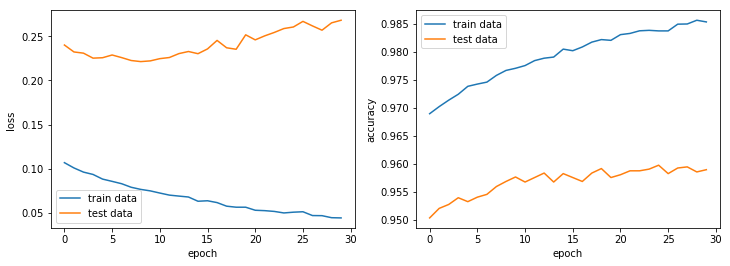

訓練集最高的準確率為0.98565，出現在epoch 28
驗證集最高的準確率為0.9598，出現在epoch 24


In [18]:
get_plots(loss_train_list,acc_train_list,loss_test_list,acc_test_list)